<a href="https://colab.research.google.com/github/sverdoot/optimizer-SUG-torch/blob/master/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/Optimization project")
os.getcwd()

file_path = "./MNIST"

try:
    os.stat(file_path)
except:
    os.mkdir(file_path)       

In [0]:
from sug import *

In [0]:
%matplotlib inline
import torch
from torch import nn
from torch import optim
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

import time

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

device

device(type='cuda', index=0)

## Data

In [0]:
batch_size = 4

In [0]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

valid_dataset = torchvision.datasets.MNIST(root='/data', train=True, 
                                        download=True, transform=transform)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                        download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [0]:
valid_size=0.15
num_train = len(trainset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))

np.random.seed(42)
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

trainloader = torch.utils.data.DataLoader(trainset, 
               batch_size=batch_size, sampler=train_sampler,
               num_workers=2)

validloader = torch.utils.data.DataLoader(valid_dataset, 
               batch_size=batch_size, sampler=valid_sampler,
               num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels:  tensor([9, 6, 7, 7])
Batch shape:  torch.Size([4, 1, 28, 28])


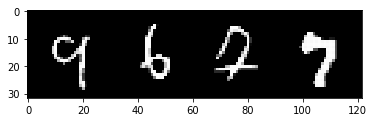

In [11]:
def show_batch(batch):
    im = torchvision.utils.make_grid(batch)
    plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))
    
dataiter = iter(trainloader)
images, labels = dataiter.next()

print('Labels: ', labels)
print('Batch shape: ', images.size())
show_batch(images)

## Models

#### Logistic Regression

In [0]:
class LR(nn.Module):
    def __init__(self):
        super(LR, self).__init__()
        self.linear1 = nn.Linear(28*28, 10)

    def forward(self, x):
        y_pred = F.log_softmax(self.linear1(x.view(batch_size, -1)), -1)
        return y_pred

###   FC

In [0]:
class FC(nn.Module):
    def __init__(self):
        super(FC, self).__init__()
        self.linear1 = nn.Linear(28*28, 256)
        self.linear2 = nn.Linear(256, 10)

    def forward(self, x):
        h_relu = F.relu(self.linear1(x.view(batch_size, -1)))
        y_pred = self.linear2(h_relu)
        return y_pred

### Conv

In [0]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32,64, kernel_size=5)
        self.fc1 = nn.Linear(3*3*64, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        #x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.conv3(x),2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = x.view(-1,3*3*64 )
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

## Train

In [0]:
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def model_step(model, optimizer, criterion, inputs, labels):
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    if model.training:
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
    if optimizer.__class__.__name__ != 'SUG':
        optimizer.step()
    else:
        def closure():
            optimizer.zero_grad()
            upd_outputs = model(inputs)
            upd_loss = criterion(upd_outputs, labels)
            upd_loss.backward()
            return upd_loss

        optimizer.step(loss, closure)

    return loss.item()

In [0]:
def train(model, trainloader, criterion, optimizer, n_epochs=2, validloader=None, eps=1e-5, print_every=1):
    tr_loss, val_loss, lips, times, grad, acc = ([] for i in range(6))
    start_time = time.time()
    model.to(device=device)
    for ep in range(n_epochs):
        model.train()
        i = 0
        for i, data in enumerate(trainloader):
            inputs, labels = data
            inputs, labels = Variable(inputs).to(device=device), Variable(labels).to(device=device)

            tr_loss.append(model_step(model, optimizer, criterion, inputs, labels))
            if optimizer.__class__.__name__ == 'SUG':
                lips.append(optimizer.get_lipsitz_const())
                grad.append(optimizer.get_sq_grad)
        times.append(time_since(start_time))
        if ep % print_every == 0:
            print("Epoch {}, training loss {}, time passed {}".format(ep, sum(tr_loss[-i:]) / i, time_since(start_time)))

        if validloader is None:
            continue
        model.zero_grad()
        model.eval()
        j = 0
        for j, data in enumerate(validloader):
            inputs, labels = data
            inputs, labels = inputs.to(device=device), labels.to(device=device)
            val_loss.append(model_step(model, optimizer, criterion, inputs, labels))
        if ep % print_every == 0:
            print("Validation loss {}".format(sum(val_loss[-j:]) / j))
        
    return tr_loss, times, val_loss, lips, grad

In [0]:
print_every = 4
n_epochs = 10
tr_loss = {}
tr_loss['sgd'] = {}
val_loss = {}
val_loss['sgd'] = {}
lrs = [0.05, 0.01, 0.005]
criterion = nn.CrossEntropyLoss(reduction="mean")

In [0]:
def concat_states(state1, state2):
    states = {
            'epoch': state1['epoch'] + state2['epoch'],
            'state_dict': state2['state_dict'],
            'optimizer': state2['optimizer'],
            'tr_loss' : state1['tr_loss'] + state2['tr_loss'],
            'val_loss' : state1['val_loss'] + state2['val_loss'],
            'lips' : state1['lips'] + state2['lips'],
            'grad' : state1['grad'] + state2['grad'],
            #'times' : state1['times'] + list(map(lambda x: x + state1['times'][-1],state2['times']))
             'times' : state1['times'] + state2['times']
             }
    return states

###LR

In [0]:
for lr in lrs:
  model = LR()
  print("SGD  lr={}, momentum=0. :".format(lr))
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.)
  tr_loss['sgd'][lr], times, val_loss['sgd'][lr], lips, grad = train(model, trainloader, criterion, optimizer, n_epochs=n_epochs, print_every=print_every, validloader=validloader)
  states = {
            'epoch': n_epochs,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'tr_loss' : tr_loss['sgd'][lr],
            'val_loss' : val_loss['sgd'][lr],
            'lips' : lips,
            'grad' : grad,
            'times' : times
             }
  torch.save(states, './MNIST/LR_' + str(lr))

SGD  lr=0.05, momentum=0. :
Epoch 0, training loss 1.1831175889721082, time passed 0m 38s
Validation loss 1.7346817483001529
Epoch 4, training loss 0.9851548817687289, time passed 3m 6s
Validation loss 0.9243420956190447
Epoch 8, training loss 0.9310133712944944, time passed 5m 36s
Validation loss 1.1689711035859476
SGD  lr=0.01, momentum=0. :
Epoch 0, training loss 0.41623996844117783, time passed 0m 32s
Validation loss 0.32225607072639145
Epoch 4, training loss 0.32428377992083196, time passed 2m 56s
Validation loss 0.3230409316380277
Epoch 8, training loss 0.31112885381527805, time passed 5m 22s
Validation loss 0.3265203488063716
SGD  lr=0.005, momentum=0. :
Epoch 0, training loss 0.4129749693272001, time passed 0m 30s
Validation loss 0.34086438555364335
Epoch 4, training loss 0.29709475929701606, time passed 2m 55s
Validation loss 0.29196425313139596
Epoch 8, training loss 0.2841329223229156, time passed 5m 20s
Validation loss 0.2948868198833449


In [0]:
l_0 = 2
model = LR()
optimizer = SUG(model.parameters(), l_0=l_0, momentum=0.)
tr_loss['sug'], times, val_loss['sug'], lips, grad = train(model, trainloader, criterion, optimizer, n_epochs=n_epochs, print_every=print_every, validloader=validloader)
states = {
            'epoch': n_epochs,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'tr_loss' : tr_loss['sug'],
            'val_loss' : val_loss['sug'],
            'lips' : lips,
            'grad' : grad,
            'times' : times
         }
torch.save(states, './MNIST/LR_sug')

### FC

In [0]:
n_epochs = 12

In [0]:
for lr in lrs:
  model = FC()
  print("SGD  lr={}, momentum=0. :".format(lr))
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.)
  tr_loss['sgd'][lr], times, val_loss['sgd'][lr], lips, grad = train(model, trainloader, criterion, optimizer, n_epochs=n_epochs, print_every=print_every, validloader=validloader)
  states = {
            'epoch': n_epochs,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'tr_loss' : tr_loss['sgd'][lr],
            'val_loss' : val_loss['sgd'][lr],
            'lips' : lips,
            'grad' : grad,
            'times' : times
             }
  torch.save(states, './MNIST/FC_' + str(lr))

SGD  lr=0.05, momentum=0. :
Epoch 0, training loss 0.2366863005871361, time passed 0m 29s
Validation loss 0.11924165910008008
Epoch 4, training loss 0.036543241790046185, time passed 2m 44s
Validation loss 0.02659412257774187
Epoch 8, training loss 0.009252302931265622, time passed 4m 57s
Validation loss 0.007337128495894416
SGD  lr=0.01, momentum=0. :
Epoch 0, training loss 0.390318907132868, time passed 0m 28s
Validation loss 0.21850812987732113
Epoch 4, training loss 0.07997714770486358, time passed 2m 43s
Validation loss 0.06550830985610355
Epoch 8, training loss 0.04263166229681311, time passed 4m 59s
Validation loss 0.0345691220396728
SGD  lr=0.005, momentum=0. :
Epoch 0, training loss 0.49476544181125587, time passed 0m 28s
Validation loss 0.2863557395032906
Epoch 4, training loss 0.13017870467198542, time passed 2m 44s
Validation loss 0.11114349794313609
Epoch 8, training loss 0.0772063676231337, time passed 4m 57s
Validation loss 0.06647039221731384


In [0]:
l_0 = 2
model = FC()
optimizer = SUG(model.parameters(), l_0=l_0, momentum=0.)
tr_loss['sug'], times, val_loss['sug'], lips, grad = train(model, trainloader, criterion, optimizer, n_epochs=n_epochs, print_every=print_every, validloader=validloader)
states = {
            'epoch': n_epochs,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'tr_loss' : tr_loss['sug'],
            'val_loss' : val_loss['sug'],
            'lips' : lips,
            'grad' : grad,
            'times' : times
         }
torch.save(states, './MNIST/FC_sug')

Epoch 0, training loss 0.2193387469148363, time passed 0m 59s
Validation loss 0.11775196808452021
Epoch 4, training loss 0.03766450093525402, time passed 5m 24s
Validation loss 0.030662210186940927
Epoch 8, training loss 0.017794447657136097, time passed 9m 37s
Validation loss 0.013901273798232293


### CNN

In [0]:
for lr in lrs:
  model = CNN()
  print("SGD  lr={}, momentum=0. :".format(lr))
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.)
  tr_loss['sgd'][lr], times, val_loss['sgd'][lr], lips, grad = train(model, trainloader, criterion, optimizer, n_epochs=n_epochs, print_every=print_every, validloader=validloader)
  states = {
            'epoch': n_epochs,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'tr_loss' : tr_loss['sgd'][lr],
            'val_loss' : val_loss['sgd'][lr],
            'lips' : lips,
            'grad' : grad,
            'times' : times
             }
  torch.save(states, './MNIST/CNN_' + str(lr))

SGD  lr=0.01, momentum=0. :
Epoch 0, training loss 0.30792822736959785, time passed 0m 50s
Validation loss 0.13387587281877472
Epoch 4, training loss 0.0733286956256355, time passed 4m 53s
Validation loss 0.07147482255601184
SGD  lr=0.005, momentum=0. :
Epoch 0, training loss 0.37557755943024357, time passed 0m 55s
Validation loss 0.1362349701132594
Epoch 4, training loss 0.07144774527515312, time passed 4m 59s
Validation loss 0.06511574609441027


In [0]:
l_0 = 2
model = CNN()
optimizer = SUG(model.parameters(), l_0=l_0, momentum=0.)
tr_loss['sug'], times, val_loss['sug'], lips, grad = train(model, trainloader, criterion, optimizer, n_epochs=n_epochs, print_every=print_every, validloader=validloader)
states = {
            'epoch': n_epochs,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'tr_loss' : tr_loss['sug'],
            'val_loss' : val_loss['sug'],
            'lips' : lips,
            'grad' : grad,
            'times' : times
         }
torch.save(states, './MNIST/CNN_sug')